---
# Binary Classification Using MNIST
---

In [12]:
%cd "/content/drive/My Drive/fastbook"
from utils import *

/content/drive/My Drive/fastbook


In [0]:
from fastai2.vision.all import *

In [14]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [0]:
files = get_image_files(path/'train')

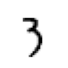

In [16]:
PILImageBW.create(files[0]).show()

In [0]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [18]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [0]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

In [20]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

---

## MNIST Loss Function

In [0]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [0]:
def sigmoid(x): return 1/(1+torch.exp(-x))

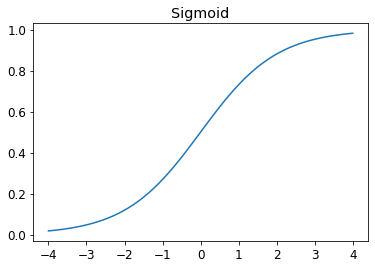

In [23]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [0]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [25]:
mnist_loss(prds, trgts)

tensor(0.4460)

---

# Training and Validation Dataloaders

In [26]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [0]:
dset = list(zip(train_x,train_y))

In [28]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [0]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))
valid_dl = DataLoader(valid_dset, batch_size=256)

---
# Basic NN Linear Model

In [0]:
# nn.Linear initializes the parameters and the creates the layer
linear_model = nn.Linear(28*28,1)

In [31]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [0]:
# Defining a basic optimizer
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [0]:
opt = BasicOptim(linear_model.parameters(), 1.)

In [0]:
def train_epoch(model):
    for xb,yb in dl:
        preds = model(xb)
        loss = mnist_loss(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [0]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [0]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [0]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [38]:
train_model(linear_model, 20)

0.4932 0.7222 0.8589 0.916 0.9365 0.9482 0.957 0.9634 0.9658 0.9673 0.9697 0.9717 0.9731 0.9746 0.9761 0.9761 0.9775 0.978 0.9785 0.9785 

In [39]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), 1.)
train_model(linear_model, 20)

0.4932 0.8247 0.8462 0.9141 0.9355 0.9473 0.9565 0.9624 0.9658 0.9668 0.9702 0.9722 0.9736 0.9746 0.9761 0.9761 0.9775 0.9785 0.9785 0.9785 

In [40]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(10, lr=1.)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637093,0.502737,0.495584,00:00
1,0.369546,0.272815,0.745339,00:00
2,0.141560,0.154224,0.861629,00:00
3,0.065627,0.097380,0.918057,00:00
4,0.037399,0.073108,0.936703,00:00
5,0.026166,0.059512,0.948970,00:00
6,0.021419,0.050921,0.957311,00:00
7,0.019218,0.045126,0.963199,00:00
8,0.018039,0.041000,0.966143,00:00
9,0.017289,0.037925,0.967125,00:00


---
# Adding non-linearity

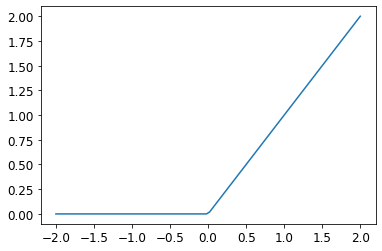

In [41]:
plot_function(F.relu)

In [42]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.291154,0.411959,0.505888,00:00
1,0.137893,0.219170,0.820412,00:00
2,0.077526,0.111162,0.919038,00:00
3,0.051734,0.075844,0.943081,00:00
4,0.039647,0.059599,0.958292,00:00
5,0.033396,0.050432,0.963199,00:00
6,0.029760,0.044631,0.966634,00:00
7,0.027371,0.040654,0.967615,00:00
8,0.025637,0.037754,0.968106,00:00
9,0.024289,0.035534,0.970559,00:00


In [43]:
d = pd.DataFrame(learn.recorder.values, columns= ['train_loss', 'valid_loss', 'accuracy'])
d.tail()

,train_loss,valid_loss,accuracy
35,0.014766,0.021300,0.982826
36,0.014634,0.021147,0.982826
37,0.014506,0.021002,0.982336
38,0.014384,0.020865,0.982336
39,0.014265,0.020736,0.982336


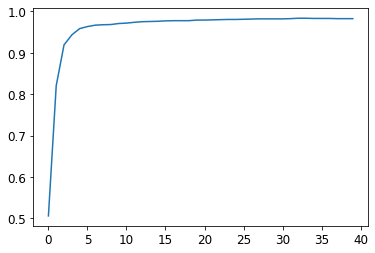

In [44]:
plt.plot(d['accuracy'])

---